## Imports

In [1]:
from collections import OrderedDict
from functools import partial
from shapely.geometry import Polygon, Point
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from bbtoolkit.data import Cached
from bbtoolkit.preprocessing.environment.builders import EnvironmentBuilder
from bbtoolkit.preprocessing.environment.compilers import DynamicEnvironmentCompiler
from bbtoolkit.structures.geometry import Texture, TexturedPolygon
import matplotlib.pyplot as plt
from bbtoolkit.preprocessing.environment.viz import plot_polygon
from bbtoolkit.preprocessing.environment.compilers.callbacks import TransparentObjects
from bbtoolkit.preprocessing.environment.visible_planes import LazyVisiblePlaneWithTransparancy
import numpy as np
from bbtoolkit.preprocessing.environment.fov import FOVManager
from bbtoolkit.preprocessing.environment.fov.ego import EgoManager
from bbtoolkit.preprocessing.environment.viz import plot_arrow
from bbtoolkit.preprocessing.environment import Environment
from matplotlib.backend_bases import KeyEvent

## Create Environment

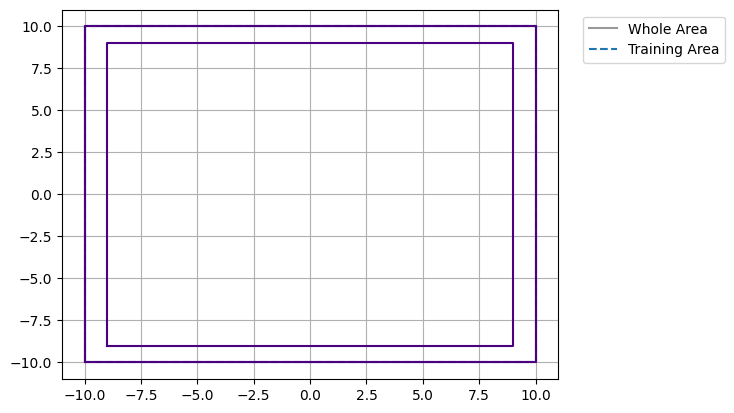

In [2]:
min_xy, max_xy = -10, 10 # create the box of size 20x20
min_train_x, max_train_x, min_train_y, max_train_y = -10, 10, -10, 10 # create the training area of size 20x10
res = 0.2 # set grid resolution

builder = EnvironmentBuilder(
    min_xy,
    max_xy,
    (min_train_x, min_train_y),
    (max_train_x, max_train_y),
    res=res
)
builder.add_wall(
    TexturedPolygon(
        Polygon(
            [
                (-10, -10),
                (-10, 10),
                (10, 10),
                (10, -10)
            ],
            holes=[
                [
                    (-9, -9),
                    (-9, 9),
                    (9, 9),
                    (9, -9)
                ]
            ]
        ),
        texture=Texture(
            1,
            '#4b0082',
            'main_wall'
        )
    )
)
_ = builder.plot()


In [3]:
builder.save('../dev/env.ini')

## Set up the compiler

In [3]:
cache_manager = Cached(cache_storage=OrderedDict(), max_size=10000)
compiler = DynamicEnvironmentCompiler(
    builder,
    partial(
        LazyVisiblePlaneWithTransparancy,
        cache_manager=cache_manager,
    ),
    callbacks=TransparentObjects()
)

compiler.add_object(
    # some polygon:
    TexturedPolygon(
        [
            (2, 2),
            (2, 4),
            (4, 4),
            (4, 2)
        ],
        texture=Texture(
            21,
            '#ae03bb',
            'obj_bound_new'
        )
    ),
    TexturedPolygon(
        [
            (-6, 3),
            (-6, 4),
            (-4, 4),
            (-4, 3)
        ],
        texture=Texture(
            21,
            '#ae03bb',
            'obj_bound_new'
        )
    ),
    TexturedPolygon(
        [
            (-3, -3),
            (-3, -1),
            (-1, -1),
            (-1, -3)
        ],
        texture=Texture(
            22,
            '#e435f2',
            'obj_bound_new'
        )
    ),
    TexturedPolygon(
        [
            (7, 2),
            (8, 2),
            (8, -2),
            (7, -2)
        ],
        texture=Texture(
            21,
            '#ae03bb',
            'obj_bound_new'
        )
    ),
    TexturedPolygon(
        [
            (-5, -7),
            (-5, -8),
            (-7, -8),
            (-7, -7)
        ],
        texture=Texture(
            21,
            '#ae03bb',
            'obj_bound_new'
        )
    )
)

compiler.add_wall(
    TexturedPolygon(
        [
            Point(5, 5),
            Point(5, -5),
            Point(6, -5),
            Point(6, 5)
        ],
        texture=Texture(
            21,
            '#4b0082',
            'wall_bound_new2'
        )
    )
)

## Set up point of view

In [4]:
fov_angle = np.pi/2
position = 0, 0
direction = -4*np.pi/5
fov_manager = FOVManager(compiler.environment, fov_angle)

In [5]:
compiler.save('../dev/compiler.pkl')

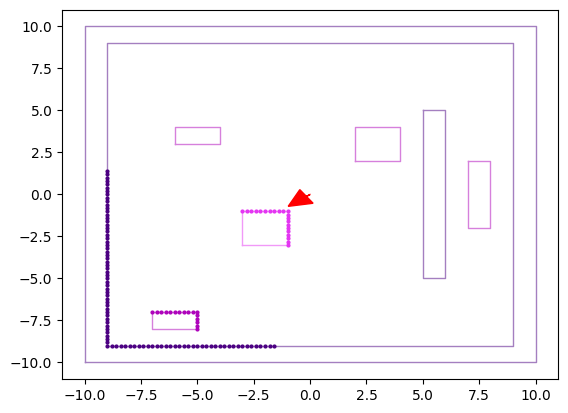

In [5]:
env = compiler.environment

walls_fov, objects_fov = fov_manager(position, direction)

fig, ax = plt.subplots()
fig = plot_arrow(direction, *position, ax=ax)

for i, obj in enumerate(env.objects + env.walls):
    plot_polygon(obj.polygon, ax=ax, alpha=0.5, linewidth=1)

for wall, poly in zip(walls_fov, compiler.environment.walls):
    ax.plot(wall[:, 0], wall[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)

for obj, poly in zip(objects_fov, compiler.environment.objects):
    ax.plot(obj[:, 0], obj[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)

## Compile egocentric POV

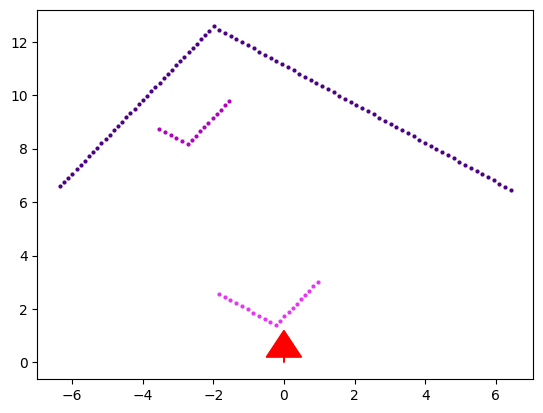

In [6]:
env = compiler.environment

ego_manager = EgoManager(fov_manager)

walls_ego, objects_ego = ego_manager(position, direction)

fig, ax = plt.subplots()
fig = plot_arrow(np.pi/2, *(0, 0), ax=ax)

for wall, poly in zip(walls_ego, compiler.environment.walls):
    ax.plot(wall[:, 0], wall[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)

for obj, poly in zip(objects_ego, compiler.environment.objects):
    ax.plot(obj[:, 0], obj[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)

## Interactive environment

In [20]:
class AgentPlotter:
    """
    A class for visualizing an agent's movement and perception in an environment.

    Attributes:
        env (Environment): The environment in which the agent operates.
        fov (FOVManager): The field of view manager for the agent.
        ego (EgoManager): The ego-centric manager for transforming coordinates.
        x (float): The agent's current x-coordinate.
        y (float): The agent's current y-coordinate.
        angle (float): The agent's current orientation angle in radians.
        move_step (float): The step size for moving the agent.
        angle_step (float): The step size for rotating the agent.
        fig (matplotlib.figure.Figure): The matplotlib figure object for plotting.
        ax1 (matplotlib.axes.Axes): The first subplot axis for the global view.
        ax2 (matplotlib.axes.Axes): The second subplot axis for the ego-centric view.

    Methods:
        update_agent(dx, dy, dangle): Updates the agent's position and orientation and redraws the plot.
        on_key(event): Handles key press events to control the agent.
        run(): Initiates the visualization by showing the plot.
    """
    def __init__(
        self,
        env: Environment,
        fov: FOVManager,
        ego: EgoManager
    ):
        """
        Initializes the AgentPlotter with the environment, FOVManager, and EgoManager.

        Args:
            env (Environment): The environment in which the agent operates.
            fov (FOVManager): The field of view manager for the agent.
            ego (EgoManager): The ego-centric manager for transforming coordinates.
        """
        self.env = env
        self.fov = fov
        self.ego = ego

        # Initial coordinates and angle
        self.x, self.y, self.angle = 0, 0, 0

        # Step size for moving and rotating
        self.move_step = 0.5
        self.angle_step = np.pi / 20  # radians

        # Create a figure and a plot
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2)
        plt.subplots_adjust(bottom=0.2)

        # Set the limits of the plot
        self.ax1.set_xlim(-10, 10)
        self.ax1.set_ylim(-10, 10)
        self.ax2.set_xlim(-20, 20)
        self.ax2.set_ylim(-20, 20)

        # Connect the key press event to the handler
        self.fig.canvas.mpl_connect('key_press_event', self.on_key)

    def update_agent(self, dx: float = 0, dy: float = 0, dangle: float = 0):
        """
        Updates the agent's position and orientation based on the given deltas and redraws the plot.

        Args:
            dx (float): The change in the x-coordinate.
            dy (float): The change in the y-coordinate.
            dangle (float): The change in the orientation angle in radians.
        """
        dx, dy = self.ego.rotate([(dx, dy)], -self.angle)[0]
        self.x += dx
        self.y += dy
        self.angle += dangle
        walls_fov, objects_fov = self.fov((self.x, self.y), self.angle)

        self.ax1.clear(), self.ax2.clear()
        self.ax1.set_xlim(-10, 10)
        self.ax1.set_ylim(-10, 10)
        self.ax2.set_xlim(-20, 20)
        self.ax2.set_ylim(-20, 20)
        _ = plot_arrow(self.angle, *(self.x, self.y), ax=self.ax1)

        for obj in self.env.objects + self.env.walls:
            plot_polygon(obj.polygon, ax=self.ax1, alpha=0.5, linewidth=1)

        for wall, poly in zip(walls_fov, self.env.walls):
            self.ax1.plot(wall[:, 0], wall[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)

        for obj, poly in zip(objects_fov, self.env.objects):
            self.ax1.plot(obj[:, 0], obj[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)

        walls_ego, objects_ego = self.ego((self.x, self.y), self.angle)

        _ = plot_arrow(np.pi/2, 0, -.75, ax=self.ax2)

        for wall, poly in zip(walls_ego, self.env.walls):
            self.ax2.plot(wall[:, 0], wall[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)

        for obj, poly in zip(objects_ego, self.env.objects):
            self.ax2.plot(obj[:, 0], obj[:, 1], 'o', color=poly.polygon.texture.color, markersize=2)

        self.fig.canvas.draw()

    def on_key(self, event: KeyEvent):
        """
        Handles key press events to control the agent's movement and rotation.

        Args:
            event (KeyEvent): The key event containing information about the pressed key.
        """
        if event.key == 'w':
            self.update_agent(dx=self.move_step)
        elif event.key == 'a':
            self.update_agent(dy=self.move_step)
        elif event.key == 's':
            self.update_agent(dx=-self.move_step)
        elif event.key == 'd':
            self.update_agent(dy=-self.move_step)
        elif event.key == 'q':
            self.update_agent(dangle=self.angle_step)
        elif event.key == 'e':
            self.update_agent(dangle=-self.angle_step)

    def run(self):
        """
        Initiates the visualization by updating the agent's position and showing the plot.
        """
        self.update_agent()
        plt.show()

In [22]:
%matplotlib qt

plt.rcParams['keymap.quit'].remove('q')
plt.rcParams['keymap.save'].remove('s')

In [23]:
simulator = AgentPlotter(env, fov_manager, ego_manager)
simulator.run()